# Find a plane Couette equilibrium with CloudAtlas.jl

2025-10-29. Produce data for ODE convergence plot for PRL  
2025-11-03. Revised to work with CloudAtlas package  
2025-11-11. Removed dependence on data files

  1. Construct an low-d ODE model for a symmetric subspace of plane Couette flow, 
  using Galerkin projection onto finite basis that incorporates the 
  boundary conditions & incompressibility constraint and spans a specified symmetric
  subspace of the flow. 
  2. Search for an equilibrium in the ODE. Use the projection of the Nagata
upper-equilibrium onto the basis for the initial guess.
  3. Compute the eigenvalues of the ODE equilibrium and compare to those from DNS.

## 0. Preliminaries

Load some packages and define a few functions. 

In [1]:
using LinearAlgebra, Polynomials, Plots
using Revise, DelimitedFiles, BenchmarkTools

using CloudAtlas

sx, sy, sz, tx, tz = halfbox_symmetries()

pwd()

[ Info: Precompiling CloudAtlas [b31a9ccd-01a9-4409-bcc3-9c4abd24a9a3] (cache misses: include_dependency fsize change (4))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


"/home/gibson/gitworking/CloudAtlas/notebooks"

## 1. Construct an ODE model of plane Couette flow

Construct a set of divergence-free, periodic/no-slip basis functions $\bf{\Psi}$
for expanding a velocity field, ${\bf u}({\bf x},t) = \sum_{i=1^m} x_i(t) {\bf \Psi}({\bf x})$.
Here ${\bf u}$ is the fluctuating velocity; the total velocity field is the sum of laminar
flow and the fluctuation, ${\bf u}_{tot}({\bf x},t) = y \, {\bf e}_x + {\bf u}({\bf x},t)$.

Then construct ODE model of plane Couette flow $B dx/dt = (A_1 + R^{-1} A_2) x + N(x)$ where
$B, A_1, A_2,$ and $N$ are determined by Galerkin projection of the plane Couette 
Navier-Stokes equations onto the basis. $A_1$ represents the The return values of `ODEModel` are functions
$f(x,R) = B^{-1} (A_1 + R^{-1} A_2) x + N(x)$ and $Df(x,R) = [\partial f_i/\partial x_j]$

In [2]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 1,1,3                       # Bounds on Fourier modes (J,K) and wall-normal polynomials (L)
H = [sx*sy*sz, sz*tx*tz]            # Generators of the symmetric subspace of the Nagata eqb

model = ODEModel(α, γ, J, K, L, H)  # Construct ODE model by Galerkin projection 

@show m = length(model)             # dimension of ODE model

J,K,L,m == 1,1,3,17
(2J+1)(2K+1)(2L+1) + 1 == 64
Making matrices B,A1,A2,S3...
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
m = length(model) = 17


17

Look at the first few basis functions. 

In [3]:
for n in 1:5
    println("Ψ$(model.ijkl[n,:]) = $(psistr(model.Ψ[n]))")
end

Ψ[1, 0, 0, 1] = [  (+1) (+1) (+1) (-4.0*y + 4.0*y^3)) ; 0 ; 0 ]
Ψ[1, 0, 0, 3] = [  (0.875) (+1) (+1) (5.0*y - 14.0*y^3 + 9.0*y^5)) ; 0 ; 0 ]
Ψ[1, 0, 1, 0] = [  (2.0) (+1) (+1) sin(γz) (1.0 - 1.0*y^2)) ; 0 ; 0 ]
Ψ[1, 0, 1, 2] = [  (+1) (+1) (+1) sin(γz) (1.0 - 6.0*y^2 + 5.0*y^4)) ; 0 ; 0 ]
Ψ[2, 0, 1, 1] = [  0 ; (1.3333333333333333) (+1) (+1) sin(γz) (1.0 - 2.0*y^2 + 1.0*y^4)) ; (0.6666666666666666) (+1) (+1) cos(γz) (-4.0*y + 4.0*y^3)) ]


Verify that $x=0$ is a solution (the laminar solution) of $f(x,R)$ by showing 
$\|f(0,400)\| = 0$.

In [4]:
x = zeros(m)
norm(model.f(x, 400))

0.0

## Solve for eqb using hookstep

Use a precomputed initial guess for the equilibrium solution. This guess was obtained from
projecting the Nagata solution at $L_x,L_z = 2\pi,pi$, $Re=200$ onto the $J,K,L = 1,1,3$ basis
for the $\langle \sigma_{xyz}, \tau_{xz} \rangle$ subspace using the channelflow `projectfield`
utility. 

```bash
projectfield ijkl-sxyz-sztxz-1-1-3-17d.asc EQ2Re200-48x49x48.nc eq2re200-1-1-3
```

where `ijkl-sxyz-sztxz-1-1-3-17d.asc` is a file specifying the $i,j,k,l$ indices for the 
basis set, `EQ2Re200-48x49x48.nc` is a NetCDF file containing a channelflow FlowField,
and `eq2re200-1-1-3` is a filename stub for the output file containing the 17 components
of the projection, which we will use for the initial guess.

Here we just hardcode the value of this `xguess`.

In [5]:
xguess =  [0.105, -0.0539, 0.388, -0.0172, -0.0133, 0.0113, -0.00706, 0.0240, -0.0344, 
        -0.00868, -0.01264, -0.0234, -0.0320, -0.0180, -0.00464, 0.0106, 0.0235]

17-element Vector{Float64}:
  0.105
 -0.0539
  0.388
 -0.0172
 -0.0133
  0.0113
 -0.00706
  0.024
 -0.0344
 -0.00868
 -0.01264
 -0.0234
 -0.032
 -0.018
 -0.00464
  0.0106
  0.0235

Load the data file into channel flow. EQ2 is the Nagata upper-branch equilibrium.

Newton-hookstep search for equilibrium solution of the ODE $dx/dt = f(x)$ using EQ2 projection as initial guess.

In [6]:
R = 200.0
f = x -> model.f(x,R)    # define function  f(x) = model.f(x,R) for fixed R
Df = x -> model.Df(x,R)  # define function Df(x) = model.Df(x,R) for fixed R

hookparams = SearchParams(ftol=1e-08, xtol=1e-12, Nnewton=30,Nhook=8,verbosity=0)
@time xsoln, success = hookstepsolve(f, Df, xguess)

@show norm(f(xsoln))/norm(xsoln)
@show norm(xsoln)
@show success;

  1.343071 seconds (1.94 M allocations: 96.588 MiB, 4.29% gc time, 99.68% compilation time)
norm(f(xsoln)) / norm(xsoln) = 1.4675882928339687e-10
norm(xsoln) = 0.5383294861140016
success = true


In [7]:
xsoln

17-element Vector{Float64}:
  0.16764501248647412
 -0.01855242950817851
  0.4864080000706215
 -0.09759477600078535
 -0.03411986452074735
 -0.010665050809627217
 -0.017317132698150793
  0.020113317588461525
 -0.0357290882423809
 -0.008809478639520451
 -0.018431734657223933
 -0.04736482526089203
 -0.0460904528729951
 -0.03157916693349783
  0.0010374375188441235
  0.01601957686431257
  0.07702704664219102

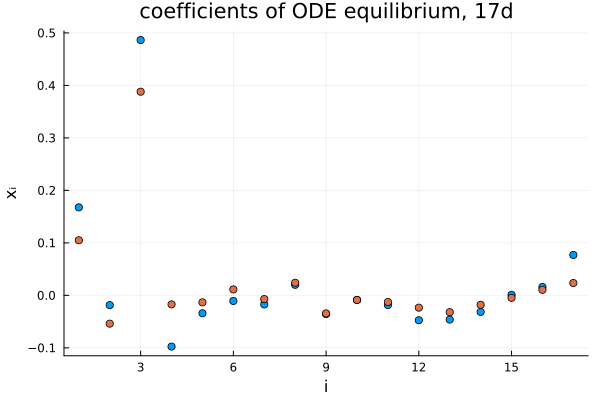

In [8]:
using Plots

scatter(1:m, xsoln, label="x solution")
scatter!(1:m, xguess, label="x guess")
plot!(xlabel="i", ylabel="xᵢ", legend=:none, title="coefficients of ODE equilibrium, $(m)d")

The likeness of ODE equilibrium (x solution) to projection of the Nagata solution
(x guess) means these two points are nearby in the low-d symmetric subspace.
The ODE equilibrium represents a rough force balance among the fundamental 
Fourier-polynomial modes very similar to the same modes in a highly-resolved
DNS computation. 

### Eigenvalues 

Compute the eigenvalues of the ODE equilibrium. The DNS eqb has just one real unstable eigenvalue.
With such a crude discretization, the ODE eigenvalues are quite different.

In [9]:
@time λODE = sort(eigvals(Df(xsoln)), by = λ -> real(λ), rev=:true)
λODE[1:10]

  0.505503 seconds (385.76 k allocations: 19.297 MiB, 97.89% compilation time)


10-element Vector{ComplexF64}:
   0.09395778503842131 - 0.16380273520303404im
   0.09395778503842131 + 0.16380273520303404im
   0.04460084153921053 + 0.0im
  0.024120522516901194 - 0.5786157605982993im
  0.024120522516901194 + 0.5786157605982993im
 -0.051225013221144804 + 0.0im
   -0.1304111908514997 - 0.17266433696721598im
   -0.1304111908514997 + 0.17266433696721598im
  -0.16183109494798625 - 0.3083313347150289im
  -0.16183109494798625 + 0.3083313347150289im

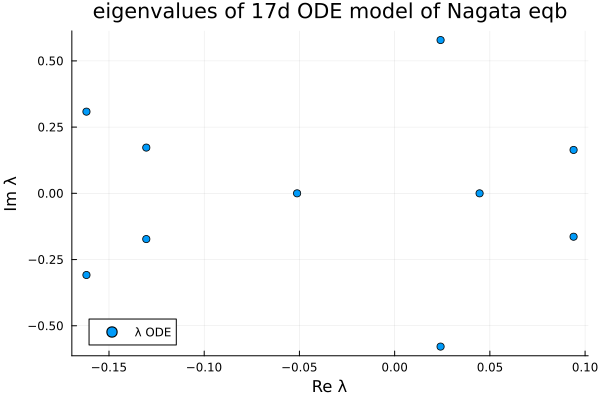

In [10]:
n=10
scatter(λODE[1:n], markersize=4, markershape=:circle, label="λ ODE")
plot!(xlabel = "Re λ", ylabel="Im λ", legend=:bottomleft)
plot!(title="eigenvalues of $(m)d ODE model of Nagata eqb")